In [61]:
import joblib

bundle1 = joblib.load("../../saved-models/merged/merged_hgb.pkl")
hgb_model = bundle1["model"]
hgb_thr = bundle1.get("threshold", 0.5)

bundle2 = joblib.load("../../saved-models/merged/merged_knn.pkl")
knn_model = bundle2["model"]
knn_thr = bundle2.get("threshold", 0.5)

rf = joblib.load("../../saved-models/merged/optimal_rf.pkl")
svc= joblib.load("../../saved-models/merged/optimal_svc.pkl")

from pathlib import Path

ARTS = Path("../../saved-models/merged")
ARTS.mkdir(parents=True, exist_ok=True)

In [43]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def plot_metrics_vs_threshold(y_true, y_proba, title="Metrics vs Threshold"):
    thresholds = np.linspace(0.0, 1.0, 501)
    accs, precs, recs, f1s = [], [], [], []
    for t in thresholds:
        y_pred = (y_proba >= t).astype(int)
        accs.append(accuracy_score(y_true, y_pred))
        precs.append(precision_score(y_true, y_pred, zero_division=0))
        recs.append(recall_score(y_true, y_pred, zero_division=0))
        f1s.append(f1_score(y_true, y_pred, zero_division=0))

    plt.figure(figsize=(8,5))
    plt.plot(thresholds, accs, label="Accuracy")
    plt.plot(thresholds, precs, label="Precision")
    plt.plot(thresholds, recs, label="Recall")
    plt.plot(thresholds, f1s, label="F1")
    plt.xlabel("Threshold")
    plt.ylabel("Score")
    plt.ylim(0, 1.05)
    plt.title(title)
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.show()

In [44]:
import pandas as pd 
from sklearn.linear_model import LogisticRegression

X_train = pd.read_csv("../../datasets/merged/X_train_imputed_scaled.csv", index_col=0)
X_test = pd.read_csv("../../datasets/merged/X_test_imputed_scaled.csv",  index_col=0)
y_train = pd.read_csv("../../datasets/merged/y_train.csv", index_col=0)["label"]
y_test = pd.read_csv("../../datasets/merged/y_test.csv",  index_col=0)["label"]
groups = pd.read_csv("../../datasets/merged/groups.csv", index_col=0)["star_key"]

meta_base = LogisticRegression() 

param_grid = {
    "solver": ["lbfgs"],
    "penalty": ["l2"],
    "C": [1e-3, 3e-3, 1e-2, 3e-2, 0.1, 0.3, 1.0],
    "class_weight": [None, "balanced"],
    "max_iter": [5000],
    "tol": [1e-4],
}

In [45]:
from sklearn.model_selection import GroupKFold
import numpy as np 

gkf = GroupKFold(n_splits=5)
splits = list(gkf.split(X_train, y_train, groups=groups))

bases_1 = [("hgb", hgb_model), ("rf", rf)]
Z_train_1 = np.zeros((X_train.shape[0], len(bases_1))) 

In [46]:
from sklearn.base import clone
from sklearn.model_selection import RandomizedSearchCV

for m, (name, model) in enumerate(bases_1): 
    oof = np.zeros(X_train.shape[0])
    for training, test in splits:
        mdl = clone(model)          
        mdl.fit(X_train.iloc[training], y_train.iloc[training])
        oof[test] = mdl.predict_proba(X_train.iloc[test])[:, 1]
    Z_train_1[:, m] = oof

grid_meta = RandomizedSearchCV(
    estimator=meta_base,
    param_distributions=param_grid,
    scoring="average_precision",
    cv=splits,      
    n_jobs=-1,
    refit=True,
    verbose=1
)

Z_test = np.column_stack([
    clone(model).fit(X_train, y_train).predict_proba(X_test)[:, 1]
    for _, model in bases_1
])

grid_meta.fit(Z_train_1, y_train) 
best_model = grid_meta.best_estimator_  
print("Best PR-AUC:", grid_meta.best_score_)
print("Best best params:", grid_meta.best_params_)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best PR-AUC: 0.9272006481629012
Best best params: {'tol': 0.0001, 'solver': 'lbfgs', 'penalty': 'l2', 'max_iter': 5000, 'class_weight': 'balanced', 'C': 1.0}


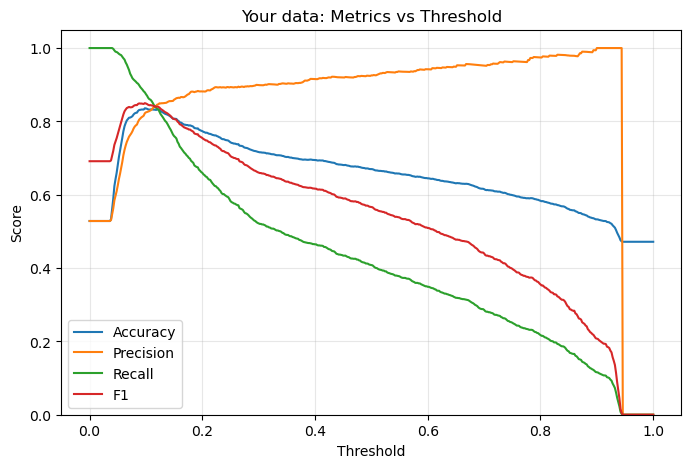

In [47]:
y = best_model.predict_proba(Z_test)[:, 1]

plot_metrics_vs_threshold(y_test, y, title="Your data: Metrics vs Threshold")

In [ ]:
from sklearn.metrics import confusion_matrix

meta_prob = best_model.predict_proba(Z_test)[:, 1]

thresholds = np.linspace(0.0, 1.0, 101)  
rows = []
for thr in thresholds:
    y_hat = (meta_prob >= thr).astype(int)
    p = precision_score(y_test, y_hat, zero_division=0)
    r = recall_score(y_test, y_hat, zero_division=0)
    f1 = f1_score(y_test, y_hat, zero_division=0)
    rows.append((thr, p, r, f1))

cand = [(thr, p, r, f1) for (thr, p, r, f1) in rows if f1 >= 0.80]
if cand:
    thr_star, p_star, r_star, f1 = max(cand, key=lambda x: x[2]) 
else:
    thr_star, p_star, r_star, f1 = 0.5, None, None, None

print(f"Chosen threshold: {thr_star:.3f}  (F1 >= 0.80)")
y_pred_thr = (meta_prob >= thr_star).astype(int)
print("Precision/Recall/F1 @ thr:", 
      precision_score(y_test, y_pred_thr), 
      recall_score(y_test, y_pred_thr),
      f1_score(y_test, y_pred_thr))
print(confusion_matrix(y_test, y_pred_thr))

Chosen threshold: 0.060  (F1 >= 0.80)
Precision/Recall/F1 @ thr: 0.7079646017699115 0.9721229449606862 0.8192771084337349
[[ 688  561]
 [  39 1360]]


In [62]:
bundle_a = {
    "model": best_model,            
    "threshold": thr_star,              
}

joblib.dump(bundle_a, ARTS / "merged_Stack_1.pkl")
print("Saved →", ARTS / "merged_Stack_1.pkl")

Saved → ../../saved-models/merged/merged_Stack_1.pkl


In [49]:
from sklearn.model_selection import GroupKFold
import numpy as np 

gkf = GroupKFold(n_splits=5)
splits = list(gkf.split(X_train, y_train, groups=groups))

bases_2 = [("knn", knn_model), ("rf", rf)]
Z_train_2 = np.zeros((X_train.shape[0], len(bases_2))) 

In [50]:
for m, (name, model) in enumerate(bases_2): 
    oof = np.zeros(X_train.shape[0])
    for training, test in splits:
        mdl = clone(model)          
        mdl.fit(X_train.iloc[training], y_train.iloc[training])
        oof[test] = mdl.predict_proba(X_train.iloc[test])[:, 1]
    Z_train_2[:, m] = oof

grid_meta_2 = RandomizedSearchCV(
    estimator=meta_base,
    param_distributions=param_grid,
    scoring="average_precision",
    cv=splits,      
    n_jobs=-1,
    refit=True,
    verbose=1
)

Z_test_2 = np.column_stack([
    clone(model).fit(X_train, y_train).predict_proba(X_test)[:, 1]
    for _, model in bases_2
])

grid_meta_2.fit(Z_train_2, y_train) 
best_model_2 = grid_meta_2.best_estimator_  
print("Best PR-AUC:", grid_meta_2.best_score_)
print("Best best params:", grid_meta_2.best_params_)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best PR-AUC: 0.9215544796233832
Best best params: {'tol': 0.0001, 'solver': 'lbfgs', 'penalty': 'l2', 'max_iter': 5000, 'class_weight': None, 'C': 0.3}


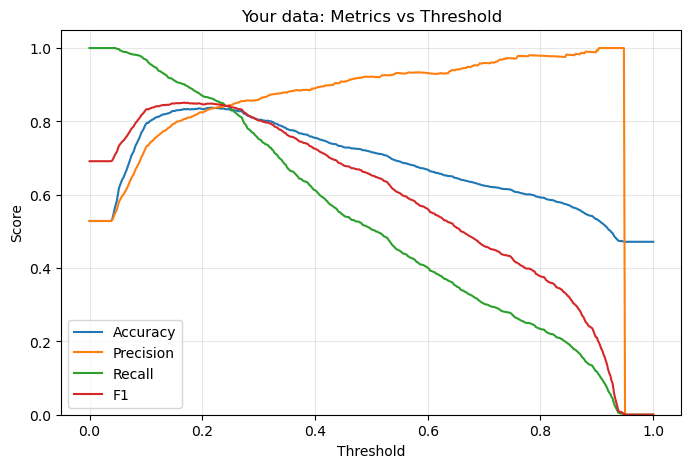

In [51]:
y_2 = best_model_2.predict_proba(Z_test_2)[:, 1]

plot_metrics_vs_threshold(y_test, y_2, title="Your data: Metrics vs Threshold")

In [52]:
meta_prob_2 = best_model_2.predict_proba(Z_test_2)[:, 1]

thresholds = np.linspace(0.0, 1.0, 101)  
rows = []
for thr in thresholds:
    y_hat = (meta_prob_2 >= thr).astype(int)
    p = precision_score(y_test, y_hat, zero_division=0)
    r = recall_score(y_test, y_hat, zero_division=0)
    f1 = f1_score(y_test, y_hat, zero_division=0)
    rows.append((thr, p, r, f1))

cand = [(thr, p, r, f1) for (thr, p, r, f1) in rows if f1 >= 0.80]
if cand:
    thr_star, p_star, r_star, f1 = max(cand, key=lambda x: x[2]) 
else:
    thr_star, p_star, r_star, f1 = 0.5, None, None, None

print(f"Chosen threshold: {thr_star:.3f}  (F1 >= 0.80)")
y_pred_thr = (meta_prob_2 >= thr_star).astype(int)
print("Precision/Recall/F1 @ thr:", 
      precision_score(y_test, y_pred_thr), 
      recall_score(y_test, y_pred_thr),
      f1_score(y_test, y_pred_thr))
print(confusion_matrix(y_test, y_pred_thr))

Chosen threshold: 0.090  (F1 >= 0.80)
Precision/Recall/F1 @ thr: 0.6945712836123795 0.9785561115082202 0.8124629080118695
[[ 647  602]
 [  30 1369]]


In [63]:
bundle_b = {
    "model": best_model_2,            
    "threshold": thr_star,              
}

joblib.dump(bundle_b, ARTS / "merged_Stack_BEST.pkl")
print("Saved →", ARTS / "merged_Stack_BEST.pkl")

Saved → ../../saved-models/merged/merged_Stack_BEST.pkl


In [53]:
gkf = GroupKFold(n_splits=5)
splits = list(gkf.split(X_train, y_train, groups=groups))

bases_3 = [("knn", knn_model), ("rf", rf), ("hgb", hgb_model)]
Z_train_3 = np.zeros((X_train.shape[0], len(bases_3))) 

In [54]:
for m, (name, model) in enumerate(bases_3): 
    oof = np.zeros(X_train.shape[0])
    for training, test in splits:
        mdl = clone(model)          
        mdl.fit(X_train.iloc[training], y_train.iloc[training])
        oof[test] = mdl.predict_proba(X_train.iloc[test])[:, 1]
    Z_train_3[:, m] = oof

grid_meta_3 = RandomizedSearchCV(
    estimator=meta_base,
    param_distributions=param_grid,
    scoring="average_precision",
    cv=splits,      
    n_jobs=-1,
    refit=True,
    verbose=1
)

Z_test_3 = np.column_stack([
    clone(model).fit(X_train, y_train).predict_proba(X_test)[:, 1]
    for _, model in bases_3
])

grid_meta_3.fit(Z_train_3, y_train) 
best_model_3 = grid_meta_3.best_estimator_  
print("Best PR-AUC:", grid_meta_3.best_score_)
print("Best best params:", grid_meta_3.best_params_)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best PR-AUC: 0.9272050072668016
Best best params: {'tol': 0.0001, 'solver': 'lbfgs', 'penalty': 'l2', 'max_iter': 5000, 'class_weight': 'balanced', 'C': 1.0}


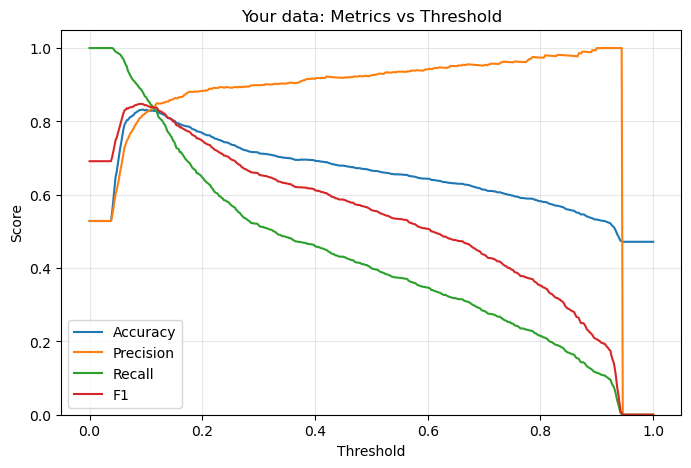

In [55]:
y_3 = best_model_3.predict_proba(Z_test_3)[:, 1]

plot_metrics_vs_threshold(y_test, y_3, title="Your data: Metrics vs Threshold")

In [56]:
meta_prob_3 = best_model_3.predict_proba(Z_test_3)[:, 1]

thresholds = np.linspace(0.0, 1.0, 101)  
rows = []
for thr in thresholds:
    y_hat = (meta_prob_3 >= thr).astype(int)
    p = precision_score(y_test, y_hat, zero_division=0)
    r = recall_score(y_test, y_hat, zero_division=0)
    f1 = f1_score(y_test, y_hat, zero_division=0)
    rows.append((thr, p, r, f1))

cand = [(thr, p, r, f1) for (thr, p, r, f1) in rows if f1 >= 0.80]
if cand:
    thr_star, p_star, r_star, f1 = max(cand, key=lambda x: x[2]) 
else:
    thr_star, p_star, r_star, f1 = 0.5, None, None, None

print(f"Chosen threshold: {thr_star:.3f}  (F1 >= 0.80)")
y_pred_thr = (meta_prob_3 >= thr_star).astype(int)
print("Precision/Recall/F1 @ thr:", 
      precision_score(y_test, y_pred_thr), 
      recall_score(y_test, y_pred_thr),
      f1_score(y_test, y_pred_thr))
print(confusion_matrix(y_test, y_pred_thr))

Chosen threshold: 0.060  (F1 >= 0.80)
Precision/Recall/F1 @ thr: 0.713459516298633 0.9699785561115082 0.8221750984550137
[[ 704  545]
 [  42 1357]]


In [64]:
bundle_c = {
    "model": best_model_3,            
    "threshold": thr_star,              
}

joblib.dump(bundle_c, ARTS / "merged_Stack_3.pkl")
print("Saved →", ARTS / "merged_Stack_3.pkl")

Saved → ../../saved-models/merged/merged_Stack_3.pkl


In [57]:
gkf = GroupKFold(n_splits=5)
splits = list(gkf.split(X_train, y_train, groups=groups))

bases_4 = [("hgb", hgb_model), ("svc", svc)]
Z_train_4 = np.zeros((X_train.shape[0], len(bases_4))) 

In [58]:
for m, (name, model) in enumerate(bases_4): 
    oof = np.zeros(X_train.shape[0])
    for training, test in splits:
        mdl = clone(model)          
        mdl.fit(X_train.iloc[training], y_train.iloc[training])
        oof[test] = mdl.predict_proba(X_train.iloc[test])[:, 1]
    Z_train_4[:, m] = oof

meta_base_4 = LogisticRegression() 

param_grid = {
    "solver": ["lbfgs"],
    "penalty": ["l2"],
    "C": [1e-3, 3e-3, 1e-2, 3e-2, 0.1, 0.3, 1.0],
    "class_weight": [None, "balanced"],
    "max_iter": [5000],
    "tol": [1e-4],
}

grid_meta_4 = RandomizedSearchCV(
    estimator=meta_base_4,
    param_distributions=param_grid,
    scoring="average_precision",
    cv=splits,      
    n_jobs=-1,
    refit=True,
    verbose=1
)

Z_test_4 = np.column_stack([
    clone(model).fit(X_train, y_train).predict_proba(X_test)[:, 1]
    for _, model in bases_4
])

grid_meta_4.fit(Z_train_4, y_train) 
best_model_4 = grid_meta_4.best_estimator_  
print("Best PR-AUC:", grid_meta_4.best_score_)
print("Best best params:", grid_meta_4.best_params_)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best PR-AUC: 0.9260549235593711
Best best params: {'tol': 0.0001, 'solver': 'lbfgs', 'penalty': 'l2', 'max_iter': 5000, 'class_weight': 'balanced', 'C': 1.0}


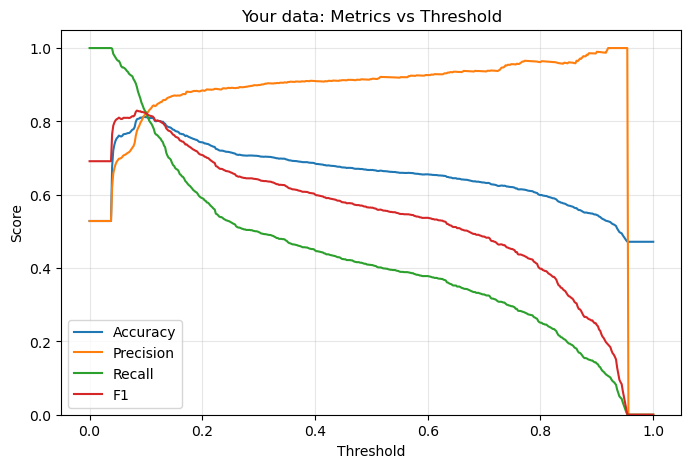

In [59]:
y_4 = best_model_4.predict_proba(Z_test_4)[:, 1]

plot_metrics_vs_threshold(y_test, y_4, title="Your data: Metrics vs Threshold")

In [60]:
meta_prob_4 = best_model_4.predict_proba(Z_test_4)[:, 1]

thresholds = np.linspace(0.0, 1.0, 101)  
rows = []
for thr in thresholds:
    y_hat = (meta_prob_4 >= thr).astype(int)
    p = precision_score(y_test, y_hat, zero_division=0)
    r = recall_score(y_test, y_hat, zero_division=0)
    f1 = f1_score(y_test, y_hat, zero_division=0)
    rows.append((thr, p, r, f1))

cand = [(thr, p, r, f1) for (thr, p, r, f1) in rows if f1 >= 0.80]
if cand:
    thr_star, p_star, r_star, f1 = max(cand, key=lambda x: x[2]) 
else:
    thr_star, p_star, r_star, f1 = 0.5, None, None, None

print(f"Chosen threshold: {thr_star:.3f}  (F1 >= 0.80)")
y_pred_thr = (meta_prob_4 >= thr_star).astype(int)
print("Precision/Recall/F1 @ thr:", 
      precision_score(y_test, y_pred_thr), 
      recall_score(y_test, y_pred_thr),
      f1_score(y_test, y_pred_thr))
print(confusion_matrix(y_test, y_pred_thr))

Chosen threshold: 0.050  (F1 >= 0.80)
Precision/Recall/F1 @ thr: 0.6938880328710837 0.9656897784131523 0.8075313807531381
[[ 653  596]
 [  48 1351]]


In [65]:
bundle_d = {
    "model": best_model_4,            
    "threshold": thr_star,              
}

joblib.dump(bundle_d, ARTS / "merged_Stack_4.pkl")
print("Saved →", ARTS / "merged_Stack_4.pkl")

Saved → ../../saved-models/merged/merged_Stack_4.pkl
